# 14wk-59: 자전거대여 / 자료분석(Autogluon)

최규빈  
2023-12-01

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-wHJGD4cGaPyhsgmNoL8d1A&si=mr1FfzkYCLGfOSGM>

# 2. Imports

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
#---#}
from autogluon.tabular import TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.common import space
#---#
import warnings
warnings.filterwarnings('ignore')

# 3. Data

ref: <https://www.kaggle.com/competitions/bike-sharing-demand>

`-` 자료 다운로드

In [4]:
!kaggle competitions download -c bike-sharing-demand

100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 829kB/s]
100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 829kB/s]

In [6]:
!unzip bike-sharing-demand.zip -d data

Archive:  bike-sharing-demand.zip
  inflating: data/sampleSubmission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          

In [9]:
sampleSubmission = pd.read_csv('data/sampleSubmission.csv')
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv') 

In [13]:
!rm -rf data
!rm bike-sharing-demand.zip

`-` 자료관찰

In [26]:
display("train",df_train,"test",df_test)

`-` train/test가 나누어진 시점 해석

In [36]:
display("train",df_train[::24][:20], "test",df_test[::24][:10])

`-` 시계열분석을 해야하나?

코드들을 확인
(<https://www.kaggle.com/c/bike-sharing-demand/code?competitionId=3948&sortBy=voteCount>)
-\> 시계열분석은 아닌것 같지않어?

`-` 데이터분석전략: 딱히 기세를 모델링할 필요를 못느끼겠음.

-   오히려 시계열을 피처엔지어링하여 회귀문제로 바꾸는게 적절하다.
-   시계열 -\> 요일,시간의 피처추출 + 외부자료를 활용하여 휴일유무
    체크 + 외부자료를 해당요일의 날씨체크 -\> lm(y~X)의 회귀문제로 해석!

# 4. 적합1 -\> 제출1

## A. 적합

In [38]:
set(df_train.columns) - set(df_test.columns)

`-` 데이터 전처리

In [39]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()
#---# 
df_train_featured = df_train_featured.drop(['casual','registered'],axis=1)

`-` step2~4

In [40]:
# step1 -- pass 
# step2
predictr = TabularPredictor(label='count')
# step3
predictr.fit(df_train_featured)
# step4 
yhat = predictr.predict(df_train_featured)
yyhat = predictr.predict(df_test_featured)

No path specified. Models will be saved in: "AutogluonModels/ag-20231209_040303"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
    Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
    presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
    presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
    presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
    presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231209_040303"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.11.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #140-Ubuntu SMP Thu Aug 4 02:23:37 UTC 

[1000]  valid_set's rmse: 136.065

`-` 적합한것을 관찰해보자.

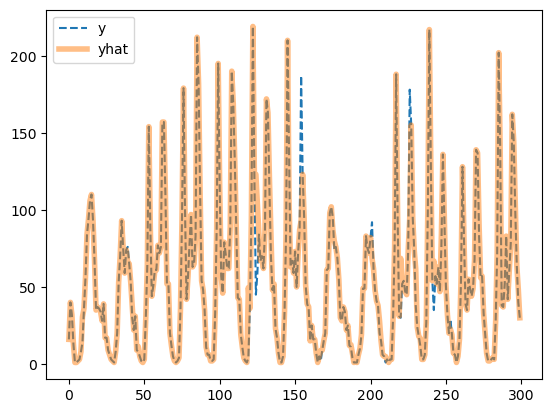

In [49]:
plt.plot(df_train['count'][:300],'--',label='y')
plt.plot(yhat[:300],alpha=0.5,lw=4,label='yhat')
plt.legend()

-   잘 맞추는데?.. (수상할 정도로)

## B. 제출

`-` 제출

In [60]:
sampleSubmission['count'] = yyhat 
sampleSubmission.to_csv("submission.csv",index=False)
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "Message"
!rm submission.csv

100%|████████████████████████████████████████| 188k/188k [00:02<00:00, 80.1kB/s]
Successfully submitted to Bike Sharing Demand

`-` 순위확인

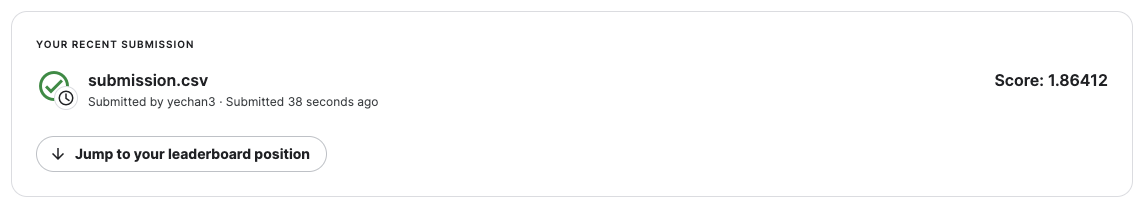

In [14]:
3171/3242 # 냈다면

`-` yyhat을 살펴봄

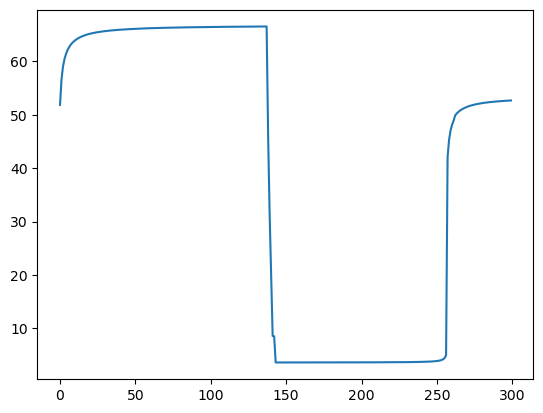

In [62]:
plt.plot(yyhat[:300])

-   yhat이랑 모양자체가 너무 다름

# 5. 적합2 -\> 제출2

## A. 피처엔지니어링

`-` 이미 시계열로 적합할 의지가 없으므로 `datetime`열은 삭제하는게
좋겠음. (인덱스의 역할만 하는 쓸모없는 변수)

In [69]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()
#----# 
df_train_featured = df_train_featured.drop(['casual','registered'],axis=1)
#--#
df_train_featured = df_train_featured.drop(['datetime'],axis=1)
df_test_featured = df_test_featured.drop(['datetime'],axis=1)

## B. 적합

`-` 조용히 적합 (verbosity=False)

In [71]:
# step1 -- pass 
# step2
predictr = TabularPredictor(label='count',verbosity=False)
# step3
predictr.fit(df_train_featured)
# step4 
yhat = predictr.predict(df_train_featured)
yyhat = predictr.predict(df_test_featured)

`-` 적합결과 시각화

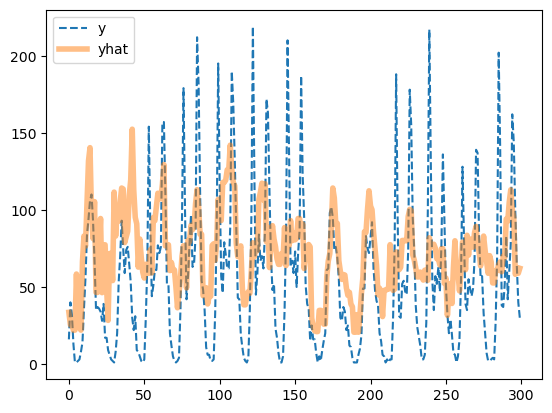

In [72]:
plt.plot(df_train['count'][:300],'--',label='y')
plt.plot(yhat[:300],alpha=0.5,lw=4,label='yhat')
plt.legend()

-   오히려 좋아

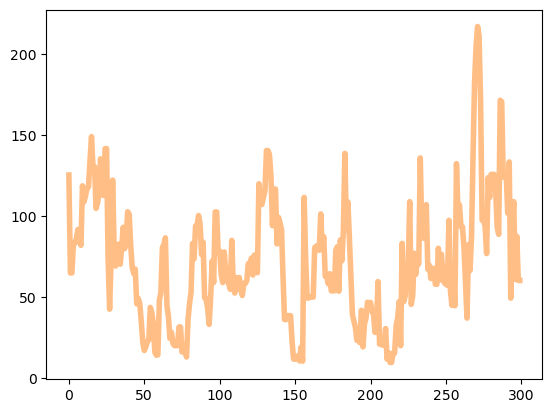

In [75]:
plt.plot(yyhat[:300],alpha=0.5,lw=4,color='C1')

`-` 더 예쁜 시각화

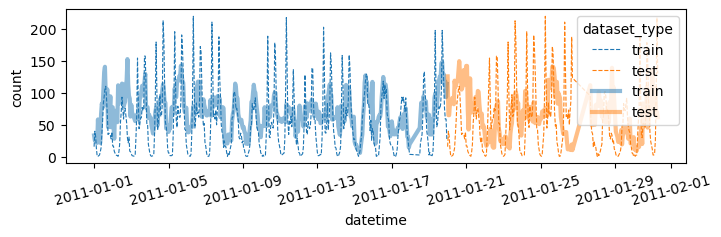

In [103]:
df = pd.concat([
    df_train.assign(count_hat = yhat, dataset_type = 'train'),
    df_test.assign(count_hat = yyhat, dataset_type = 'test')
])
df['datetime'] = pd.to_datetime(df['datetime'])
sns.lineplot(
    df.sort_values('datetime')[:(24*28)],
    x='datetime',y='count',
    hue='dataset_type',
    linestyle='--',
    lw=0.8
)
sns.lineplot(
    df.sort_values('datetime')[:(24*28)],
    x='datetime',y='count_hat',
    hue='dataset_type',
    alpha=0.5,
    lw=3
)
fig = plt.gcf()
fig.set_size_inches(8,2)
plt.xticks(rotation=15);

시각화코드를 함수로 구현

In [104]:
def plot(yhat,yyhat):
    df = pd.concat([
        df_train.assign(count_hat = yhat, dataset_type = 'train'),
        df_test.assign(count_hat = yyhat, dataset_type = 'test')
    ])
    df['datetime'] = pd.to_datetime(df['datetime'])
    sns.lineplot(
        df.sort_values('datetime')[:(24*28)],
        x='datetime',y='count',
        hue='dataset_type',
        linestyle='--',
        lw=0.8
    )
    sns.lineplot(
        df.sort_values('datetime')[:(24*28)],
        x='datetime',y='count_hat',
        hue='dataset_type',
        alpha=0.5,
        lw=3
    )
    fig = plt.gcf()
    fig.set_size_inches(8,2)
    plt.xticks(rotation=15); 
    fig.show()

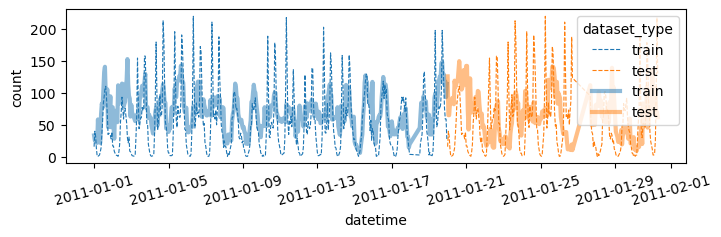

In [105]:
plot(yhat,yyhat)

## C. 제출

`-` 제출

In [107]:
sampleSubmission['count'] = yyhat 
sampleSubmission.to_csv("submission.csv",index=False)
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "Message"
!rm submission.csv

100%|████████████████████████████████████████| 188k/188k [00:02<00:00, 90.6kB/s]
Successfully submitted to Bike Sharing Demand

`-` 순위확인

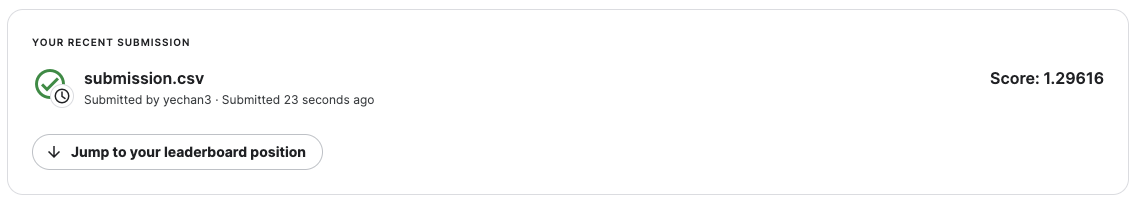

In [28]:
2951/3242 # 냈다면

## D. Pipeline Automation – 싹다 함수로 구현

In [122]:
def fit_predict(df_train_featured, df_test_featured):
    # step1 -- pass 
    # step2
    predictr = TabularPredictor(label='count',verbosity=False)
    # step3
    predictr.fit(df_train_featured)
    # step4 
    yhat = predictr.predict(df_train_featured)
    yyhat = predictr.predict(df_test_featured)
    # display
    display(predictr.leaderboard())
    return yhat, yyhat 

In [117]:
def submit(yyhat):
    sampleSubmission['count'] = yyhat 
    sampleSubmission['count'] = sampleSubmission['count'].apply(lambda x: x if x>0 else 0)
    sampleSubmission.to_csv("submission.csv",index=False)
    !kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "Message"
    !rm submission.csv

In [123]:
def auto(df_train_featured, df_test_featured):
    yhat,yyhat = fit_predict(df_train_featured, df_test_featured)
    plot(yhat,yyhat)
    submit(yyhat)

100%|█████████████████████████████████████████| 243k/243k [00:02<00:00, 110kB/s]
Successfully submitted to Bike Sharing Demand

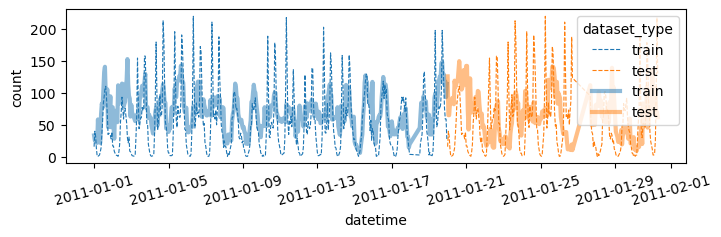

In [124]:
auto(df_train_featured,df_test_featured)

# 6. 적합3 -\> 제출3

## A. 시간정보 피처엔지니어링

In [136]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()
#----# 
df_train_featured = df_train_featured.drop(['casual','registered'],axis=1)
#--#
df_train_featured['hour'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.hour
df_test_featured['hour'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.hour
df_train_featured['weekday'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.weekday
df_test_featured['weekday'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.weekday
#--#
df_train_featured = df_train_featured.drop(['datetime'],axis=1)
df_test_featured = df_test_featured.drop(['datetime'],axis=1)

## B. 적합 -\> 시각화 -\> 제출

100%|█████████████████████████████████████████| 240k/240k [00:02<00:00, 100kB/s]
Successfully submitted to Bike Sharing Demand

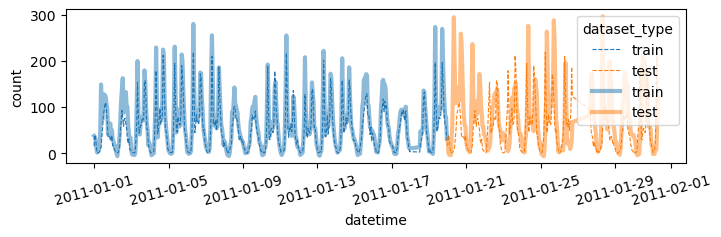

In [137]:
auto(df_train_featured,df_test_featured)

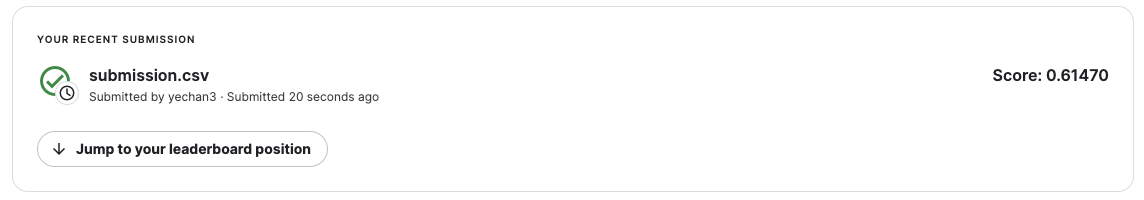

# 7. 추가적인 피처엔지니어링

## A. Step1 – 관련없는 변수 삭제

`-` 지금까지 수행한 피처엔지니어링

In [201]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()
#----# 
df_train_featured = df_train_featured.drop(['casual','registered'],axis=1)
#--#
df_train_featured['hour'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.hour
df_test_featured['hour'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.hour
df_train_featured['weekday'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.weekday
df_test_featured['weekday'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.weekday
#--#
df_train_featured = df_train_featured.drop(['datetime'],axis=1)
df_test_featured = df_test_featured.drop(['datetime'],axis=1)

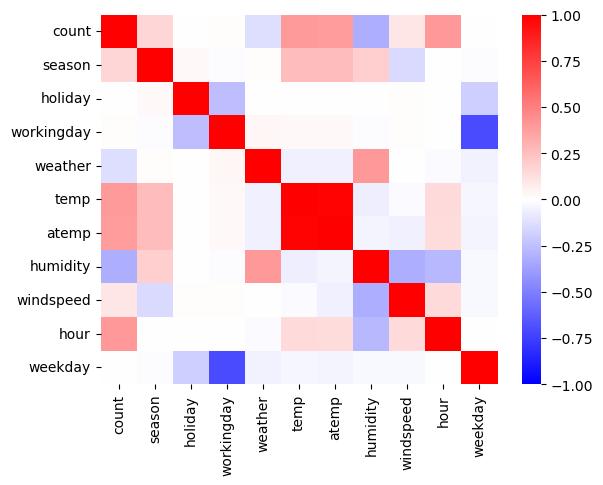

In [200]:
sns.heatmap(df_train_featured.set_index('count').reset_index().corr(),vmin=-1,cmap='bwr')

-   `holiday`, `workingday`, `weekday`는 `count`와 관련이 없어보인다.
    –\> 제외하고 분석

100%|█████████████████████████████████████████| 242k/242k [00:02<00:00, 121kB/s]
Successfully submitted to Bike Sharing Demand

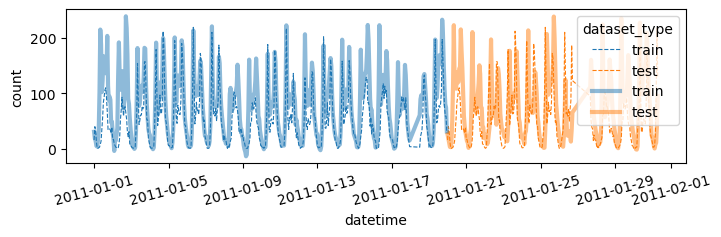

In [209]:
auto(
    df_train_featured.drop(['holiday', 'workingday', 'weekday'],axis=1),
    df_test_featured.drop(['holiday', 'workingday', 'weekday'],axis=1)
)

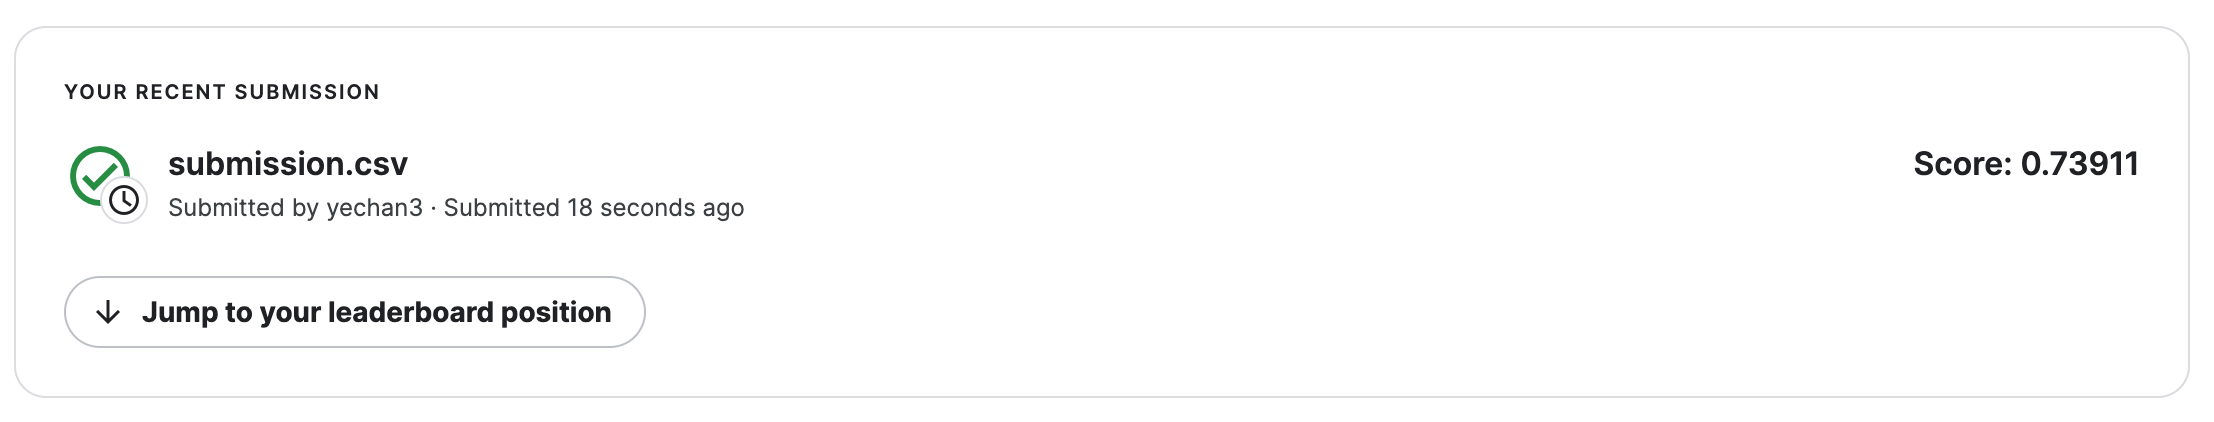

-   안좋아졌음..

`-` 왜 이런 결과가 나오는가?

In [308]:
sex =  np.array([0,0,0,0]*100+[0] + [1]+[1,1,1,1]*100 + [2]*401)
surv = np.array([0,0,0,0]*100+[1] + [0]+[1,1,1,1]*100 + [0]*401) 
surv_conti = surv + np.random.randn(len(surv))*0.1
_df = pd.DataFrame({'sex':sex, 'surv':surv, 'surv_conti':surv_conti})
_df.corr()

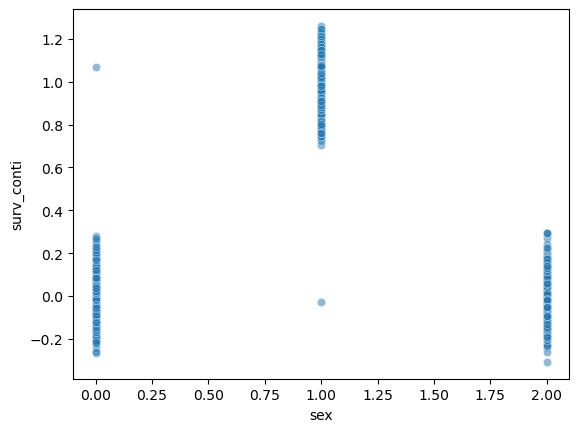

In [309]:
sns.scatterplot(_df, x='sex',y='surv_conti',alpha=0.5)

In [310]:
surv_conti.mean()

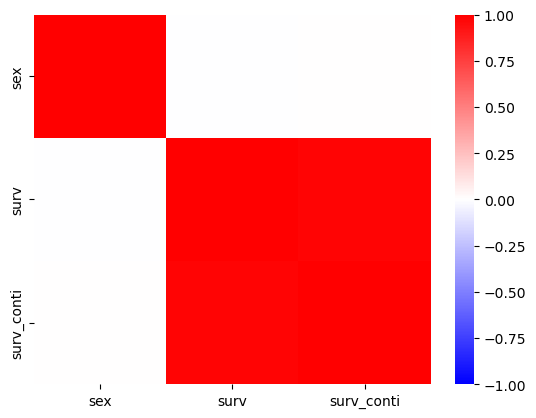

In [311]:
sns.heatmap(_df.corr(),cmap='bwr',vmin=-1)

`-` 우리의 예제

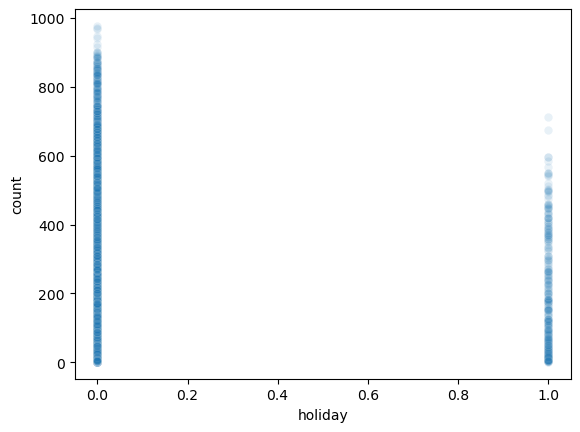

In [316]:
sns.scatterplot(
    df_train_featured,
    x='holiday',
    y='count',
    alpha=0.1
)

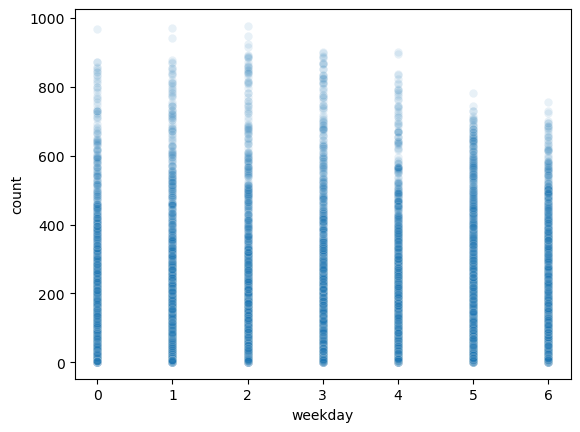

In [318]:
sns.scatterplot(
    df_train_featured,
    x='weekday',
    y='count',
    alpha=0.1
)

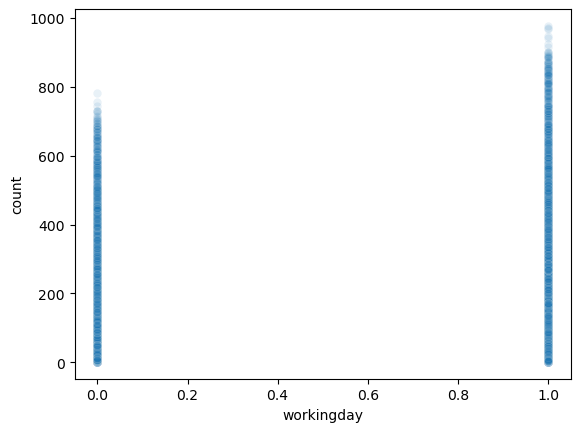

In [319]:
sns.scatterplot(
    df_train_featured,
    x='workingday',
    y='count',
    alpha=0.1
)

## B. Step2 – atemp 혹은 temp 삭제

`-` 지금까지 한 피처엔지니어링

In [320]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()
#----# 
df_train_featured = df_train_featured.drop(['casual','registered'],axis=1)
#--#
df_train_featured['hour'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.hour
df_test_featured['hour'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.hour
df_train_featured['weekday'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.weekday
df_test_featured['weekday'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.weekday
#--#
df_train_featured = df_train_featured.drop(['datetime'],axis=1)
df_test_featured = df_test_featured.drop(['datetime'],axis=1)

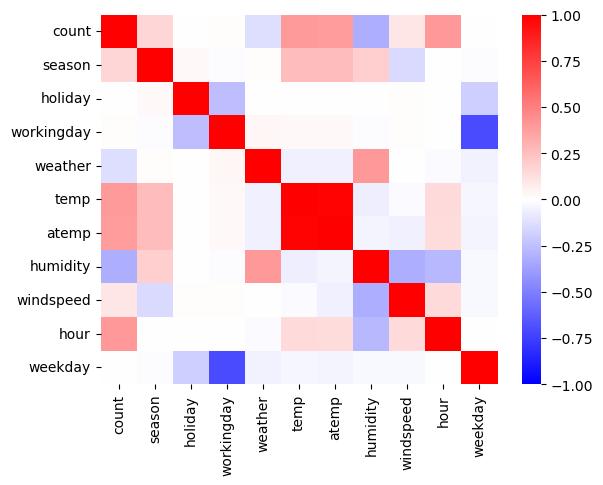

In [321]:
sns.heatmap(df_train_featured.set_index('count').reset_index().corr(),vmin=-1,cmap='bwr')

-   temp와 atemp가 동시에 있어서 공선성 문제를 만들 수 있어보임.
-   둘중 하나를 제거하는게 좋을것 같음.

100%|████████████████████████████████████████| 241k/241k [00:02<00:00, 97.9kB/s]
Successfully submitted to Bike Sharing Demand

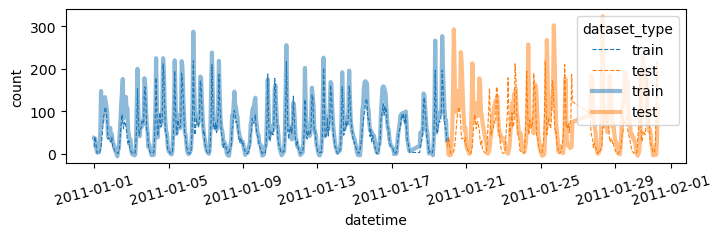

In [324]:
auto(
    df_train_featured.drop(['temp'],axis=1),
    df_test_featured.drop(['temp'],axis=1)
)

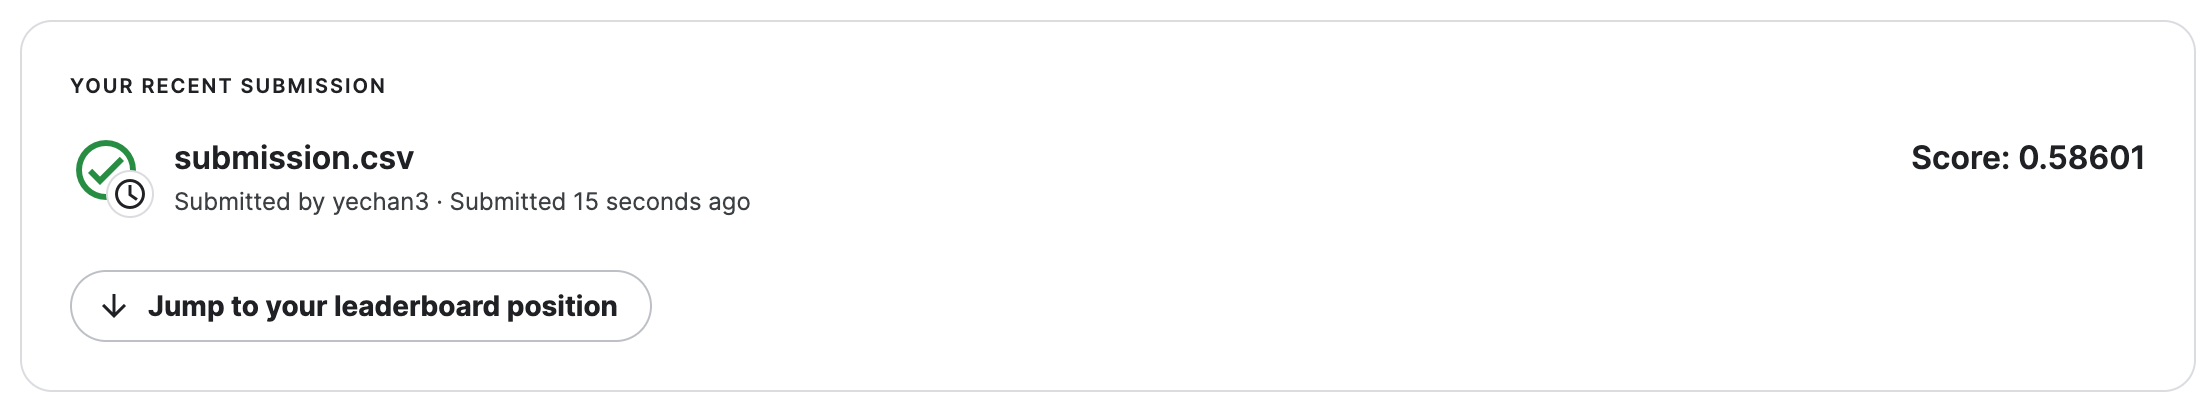

100%|█████████████████████████████████████████| 241k/241k [00:02<00:00, 104kB/s]
Successfully submitted to Bike Sharing Demand

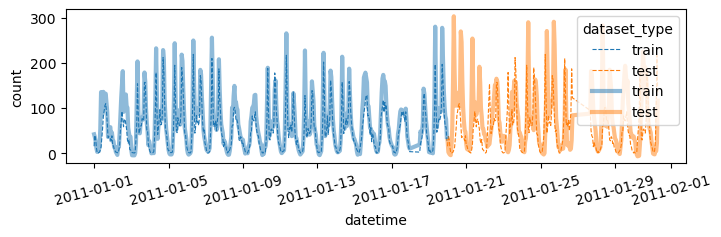

In [325]:
auto(
    df_train_featured.drop(['atemp'],axis=1),
    df_test_featured.drop(['atemp'],axis=1)
)

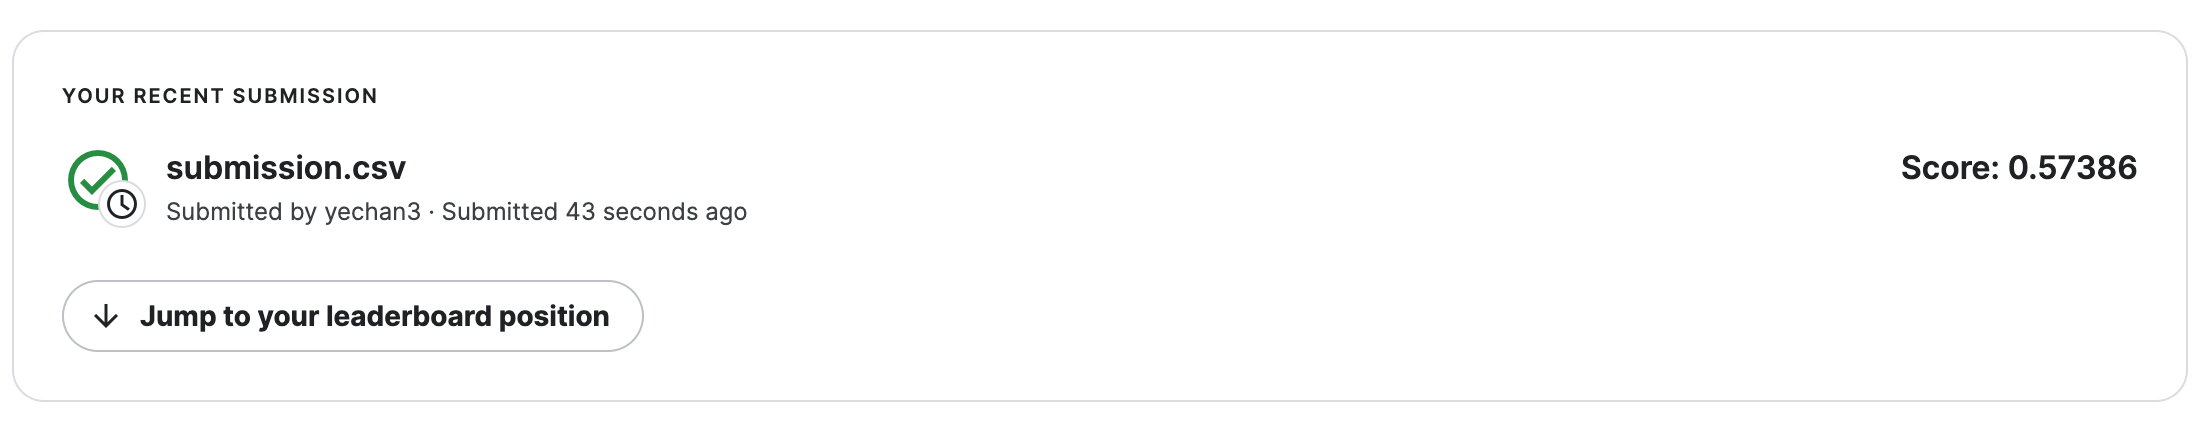

## C. Step3 – season을 범주로?

`-` 지금까지한 피처엔지니어링

In [337]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()
#----# 
df_train_featured = df_train_featured.drop(['casual','registered'],axis=1)
#--#
df_train_featured['hour'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.hour
df_test_featured['hour'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.hour
df_train_featured['weekday'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.weekday
df_test_featured['weekday'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.weekday
#--#
df_train_featured = df_train_featured.drop(['datetime'],axis=1)
df_test_featured = df_test_featured.drop(['datetime'],axis=1)
#--#
df_train_featured = df_train_featured.drop(['atemp'],axis=1)
df_test_featured = df_test_featured.drop(['atemp'],axis=1)

`-` 사실 season의 의미는
`season -  1 = spring, 2 = summer, 3 = fall, 4 = winter` 임

-   지금은 season이 1,2,3,4로 코딩되어 있는데, 이것을 문자열로 바꾸면 더
    좋지 않을까?

100%|█████████████████████████████████████████| 240k/240k [00:02<00:00, 118kB/s]
Successfully submitted to Bike Sharing Demand

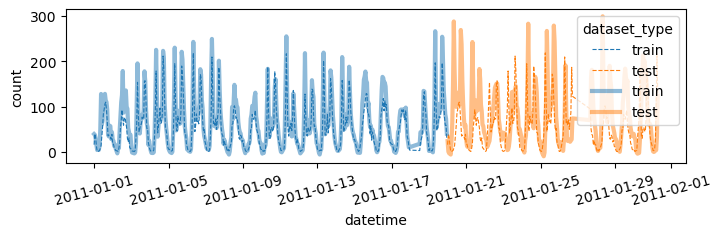

In [336]:
auto(
    df_train_featured.assign(season = df_train_featured.season.map({1:'spring',2:'summer',3:'fall',4:'winter'})),
    df_test_featured.assign(season = df_train_featured.season.map({1:'spring',2:'summer',3:'fall',4:'winter'}))
)

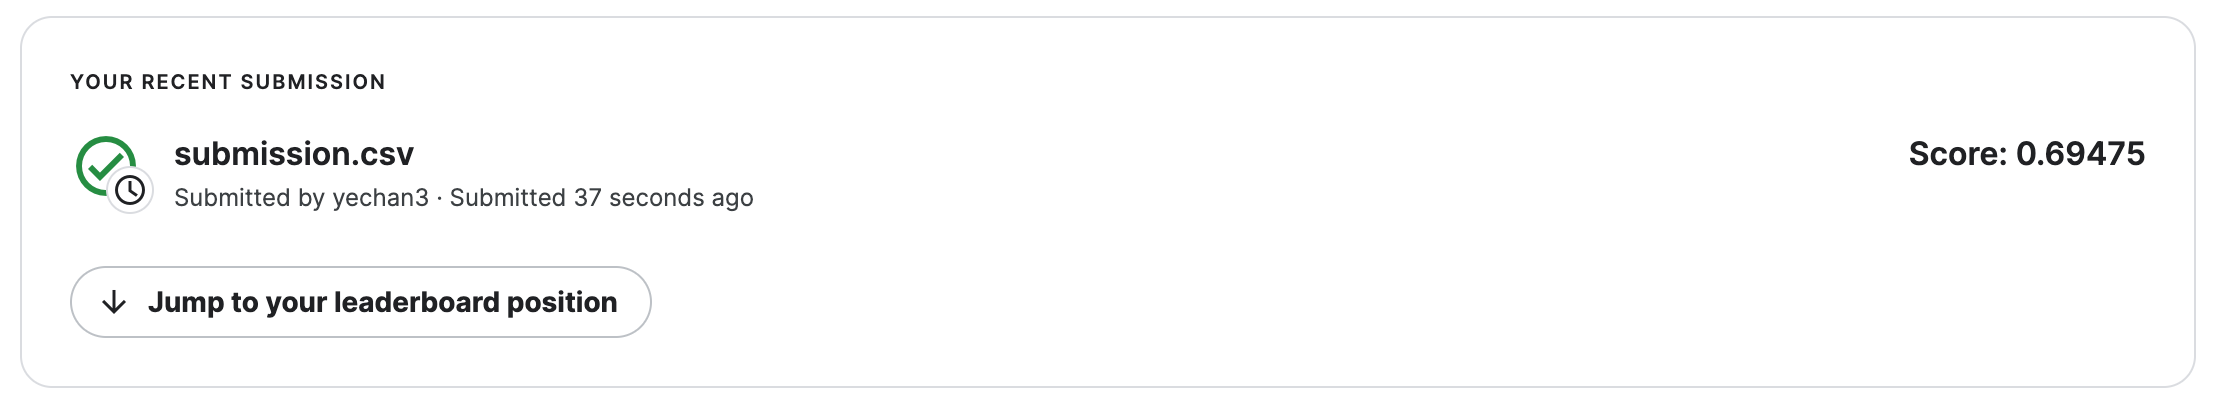

-   이건 적용하지 말자.
-   어차피 트리계열은 명목형변수를 순서형변수로 잘못 적용해도 크게
    상관없음.

## D. Step4 – $y$의 분포

`-` 지금까지한 피처엔지니어링

In [337]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()
#----# 
df_train_featured = df_train_featured.drop(['casual','registered'],axis=1)
#--#
df_train_featured['hour'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.hour
df_test_featured['hour'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.hour
df_train_featured['weekday'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.weekday
df_test_featured['weekday'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.weekday
#--#
df_train_featured = df_train_featured.drop(['datetime'],axis=1)
df_test_featured = df_test_featured.drop(['datetime'],axis=1)
#--#
df_train_featured = df_train_featured.drop(['atemp'],axis=1)
df_test_featured = df_test_featured.drop(['atemp'],axis=1)

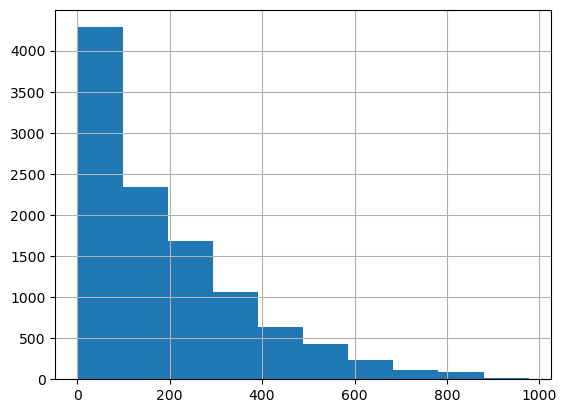

In [342]:
df_train_featured['count'].hist() # 정규분포가 아니네

In [343]:
transfomr = sklearn.preprocessing.PowerTransformer(method='box-cox')

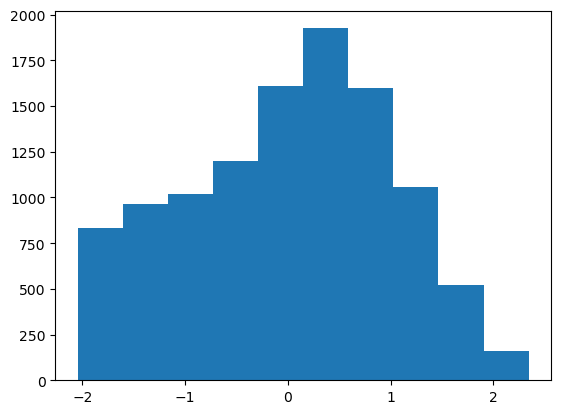

In [351]:
count2 = transfomr.fit_transform(df_train_featured[['count']]).reshape(-1)
plt.hist(count2);

In [356]:
df_train_featured.assign(count = count2)

`-` 적합

In [357]:
# step1 -- pass 
# step2 
predictr = TabularPredictor(label='count',verbosity=False)
# step3
predictr.fit(df_train_featured.assign(count = count2))
# step4
yhat = predictr.predict(df_train_featured) 
yyhat = predictr.predict(df_test_featured)

In [364]:
yhat = transfomr.inverse_transform(yhat.to_frame()).reshape(-1)
yyhat = transfomr.inverse_transform(yyhat.to_frame()).reshape(-1)

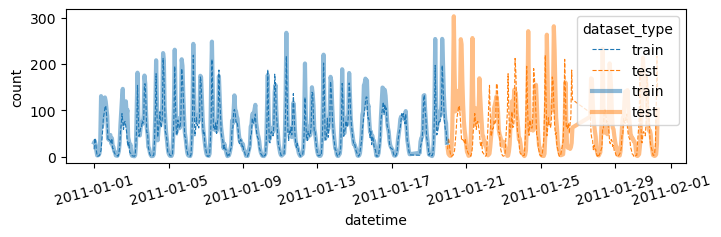

In [365]:
plot(yhat,yyhat)

In [366]:
submit(yyhat)

100%|█████████████████████████████████████████| 243k/243k [00:02<00:00, 120kB/s]
Successfully submitted to Bike Sharing Demand

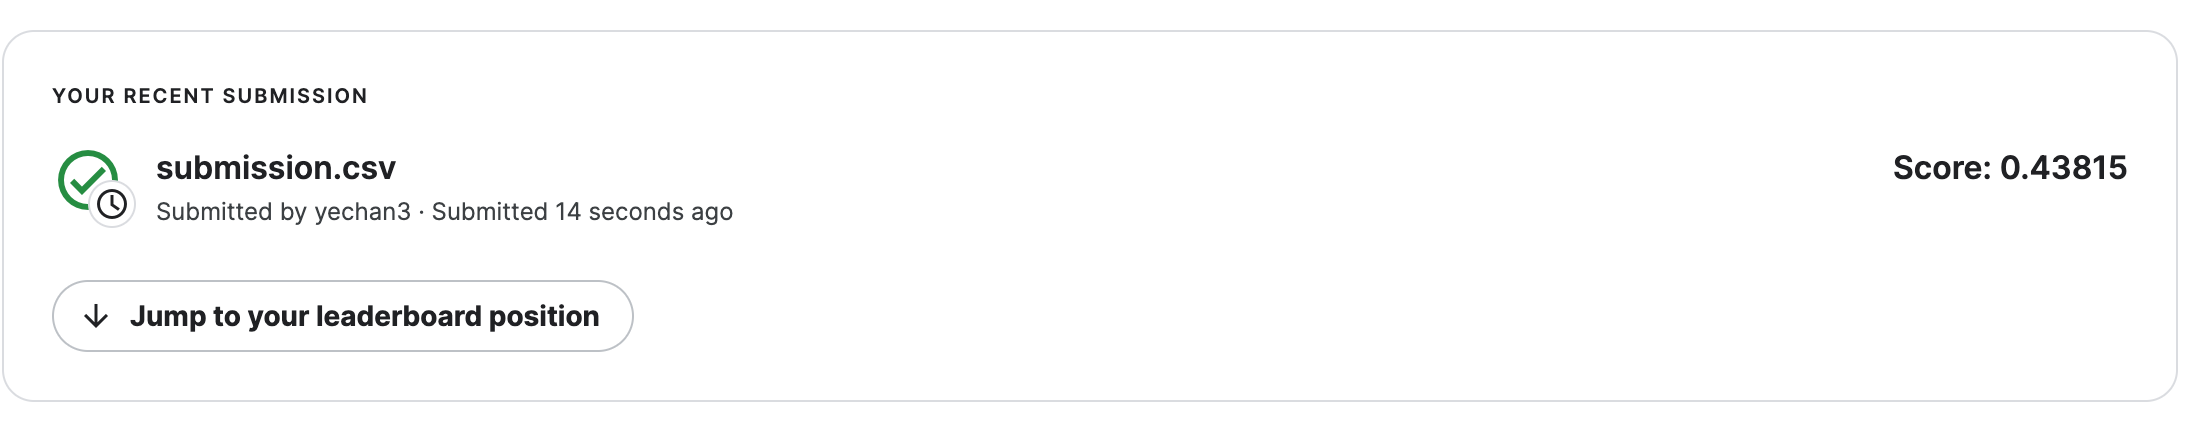

# 8. HW

box-cox transform이 아닌 `log1p`변환을 취해서 결과를 구해볼 것

In [53]:
np.log1p(0.1234), np.log(0.1234+1)

In [54]:
np.expm1(0.11635980111619529)

결과는 아래와 같음

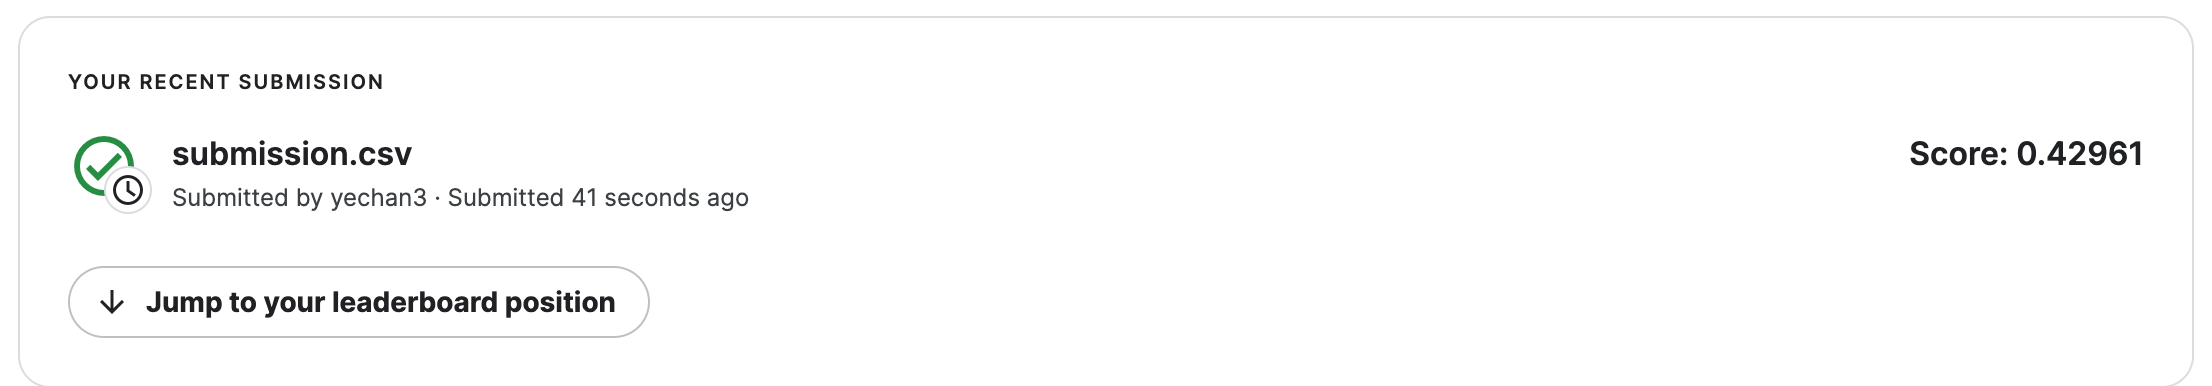